In [2]:
#setup
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *
from fastai.text.all import *

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 81.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 62.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
#locating the mental health dataset on drive and assigning it to a path
path = "/content/gdrive/MyDrive/EAI6020 - Quarter5/Assignment 3/Combined Data.csv"

In [4]:
# loading required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string
import torch
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import textwrap

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer

from xgboost import XGBClassifier

from transformers import BertTokenizer, BertModel

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# **Data Exploration and Data Cleaning**

In [5]:
# Read the CSV file and display first few records
df = pd.read_csv(path, index_col=0)
print(df.head())

                                                                        statement  \
0                                                                      oh my gosh   
1                trouble sleeping, confused mind, restless heart. All out of tune   
2  All wrong, back off dear, forward doubt. Stay in a restless and restless place   
3                   I've shifted my focus to something else but I'm still worried   
4        I'm restless and restless, it's been a month now, boy. What do you mean?   

    status  
0  Anxiety  
1  Anxiety  
2  Anxiety  
3  Anxiety  
4  Anxiety  


In [6]:
# exploring the dataset and analyzing missing rows

print(df.shape)
print(df.info())
print(df.isnull().sum())

(53043, 2)
<class 'pandas.core.frame.DataFrame'>
Index: 53043 entries, 0 to 53042
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  52681 non-null  object
 1   status     53043 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB
None
statement    362
status         0
dtype: int64


In [7]:
# Display the missing rows
print(df.isnull)

<bound method DataFrame.isnull of                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      statement  \
0                                                                                                                                                                                                                                                                                                                                                                   

In [8]:
# since classification is not possible without the statement, we will delete these
# Remove rows where 'statement' column has missing values
df = df.dropna(subset=['statement'])

In [9]:
#Reconducting missing value analysis to confirm deletion
print(df.shape)
print(df.info())
print(df.isnull().sum())
print(df.describe())

(52681, 2)
<class 'pandas.core.frame.DataFrame'>
Index: 52681 entries, 0 to 53042
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  52681 non-null  object
 1   status     52681 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB
None
statement    0
status       0
dtype: int64
                statement  status
count               52681   52681
unique              51073       7
top     what do you mean?  Normal
freq                   22   16343


In [10]:
# clean text
def clean_text(raw_text):
# Step 1: Remove HTML tags
  text = re.sub(r'<.*?>', '', raw_text)
# Step 2: Remove URLs
  text = re.sub(r'http\S+|www\S+|https\S+', '', text)
# Step 3: Remove special characters and digits
  text = re.sub(r'[^A-Za-z\s]', '', text)
# Step 4: Remove extra whitespaces
  text = re.sub(r'\s+', ' ', text).strip()
# Step 5: Convert to lowercase
  text = text.lower()
  return text
raw_text= df['statement']

In [11]:
#converting text to lowercase
df['statement'] = df['statement'].str.lower()

In [12]:
#cleaning the text
df['statement'] = df['statement'].apply(clean_text)

In [13]:
#removing stopwords
stopWords = stopwords.words('english')
df['statement'] = df['statement'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopWords)]))

In [14]:
df.head()

,statement,status
0,oh gosh,Anxiety
1,trouble sleeping confused mind restless heart tune,Anxiety
2,wrong back dear forward doubt stay restless restless place,Anxiety
3,ive shifted focus something else im still worried,Anxiety
4,im restless restless month boy mean,Anxiety


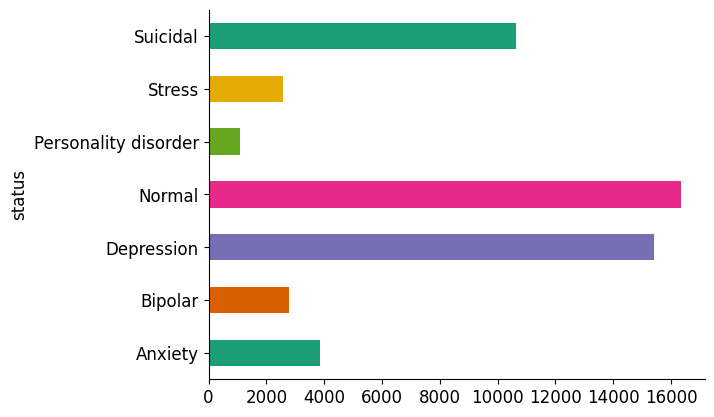

In [15]:
# Visualize status of different mental health conditions.

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('status').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [16]:
# observing different status types and their counts
df.status.value_counts()

,count
status,
Normal,16343
Depression,15404
Suicidal,10652
Anxiety,3841
Bipolar,2777
Stress,2587
Personality disorder,1077


In [17]:
#displaying one example statement from each status type
unique_status_example = df.groupby('status').first()

#displaying hte results
for status, row in unique_status_example.iterrows():
    print(f"Status: {status}")
    print("Statement:")
    print(textwrap.fill(row['statement'], width=80))  # Adjust width as needed
    print('-' * 80)  # Separator for readability

Status: Anxiety
Statement:
oh gosh
--------------------------------------------------------------------------------
Status: Bipolar
Statement:
birth control tried iud came traumatic assault taking microgestion even lowest
dose hormones bad reaction yet depo provera doesnt affect mood absolutely hate
period huff hate condoms dont even trust im fence getting fixed even sure
medicaid would cover anyway whats girl matters birth control getting lamictal
script ive amazingly well
--------------------------------------------------------------------------------
Status: Depression
Statement:
recently went breakup said still wants friends said try talks things always
hurts want lose feelings pain stop hurts much cannot even cry want hurt said
want never speak know together always hurt know still love wish never met would
much less painful lose feelings
--------------------------------------------------------------------------------
Status: Normal
Statement:
gr gr dreaming ex crush game god
-----

# **Using Natural Language Processing (NLP) for Sentiment Analysis**

In [18]:
#downloading the punkt tokenizer models
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize

#tokenize the text
tokens = word_tokenize(df['statement'][0])
print(tokens)


# tokenizing the entire dataset
df['tokens'] = df['statement'].apply(word_tokenize)

# Display tokenized text
print(df[['statement', 'tokens']].head())

['oh', 'gosh']


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


                                                    statement  \
0                                                     oh gosh   
1          trouble sleeping confused mind restless heart tune   
2  wrong back dear forward doubt stay restless restless place   
3           ive shifted focus something else im still worried   
4                         im restless restless month boy mean   

                                                                 tokens  
0                                                            [oh, gosh]  
1            [trouble, sleeping, confused, mind, restless, heart, tune]  
2  [wrong, back, dear, forward, doubt, stay, restless, restless, place]  
3            [ive, shifted, focus, something, else, im, still, worried]  
4                            [im, restless, restless, month, boy, mean]  


In [19]:
# Proceed with Stemming, we do this to normalize the words to their base form
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()

# Apply stemming
df['stemmed_tokens'] = df['tokens'].apply(lambda x: [stemmer.stem(word) for word in x])
print(df[['tokens', 'stemmed_tokens']].head())


                                                                 tokens  \
0                                                            [oh, gosh]   
1            [trouble, sleeping, confused, mind, restless, heart, tune]   
2  [wrong, back, dear, forward, doubt, stay, restless, restless, place]   
3            [ive, shifted, focus, something, else, im, still, worried]   
4                            [im, restless, restless, month, boy, mean]   

                                                         stemmed_tokens  
0                                                            [oh, gosh]  
1                  [troubl, sleep, confus, mind, restless, heart, tune]  
2  [wrong, back, dear, forward, doubt, stay, restless, restless, place]  
3                     [ive, shift, focu, someth, els, im, still, worri]  
4                            [im, restless, restless, month, boy, mean]  


In [20]:
# Lemmatization: Uses linguistic rules to reduce words to their base form
from nltk.stem import WordNetLemmatizer

# Download WordNet resources
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

# Apply lemmatization
df['lemmatized_tokens'] = df['tokens'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
print(df[['tokens', 'lemmatized_tokens']].head())

[nltk_data] Downloading package wordnet to /root/nltk_data...


                                                                 tokens  \
0                                                            [oh, gosh]   
1            [trouble, sleeping, confused, mind, restless, heart, tune]   
2  [wrong, back, dear, forward, doubt, stay, restless, restless, place]   
3            [ive, shifted, focus, something, else, im, still, worried]   
4                            [im, restless, restless, month, boy, mean]   

                                                      lemmatized_tokens  
0                                                            [oh, gosh]  
1            [trouble, sleeping, confused, mind, restless, heart, tune]  
2  [wrong, back, dear, forward, doubt, stay, restless, restless, place]  
3            [ive, shifted, focus, something, else, im, still, worried]  
4                            [im, restless, restless, month, boy, mean]  


**Using TF-IDF for Feature Extraction**

In [21]:
# using the lemmatized_tokens for feature extraction

from sklearn.feature_extraction.text import TfidfVectorizer

# Convert tokens back to sentences
df['processed_text'] = df['lemmatized_tokens'].apply(lambda x: ' '.join(x))

# Initialize the TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000)  # Limit features to 5000

# Fit and transform the text
X = tfidf.fit_transform(df['processed_text'])
print("TF-IDF matrix shape:", X.shape)

TF-IDF matrix shape: (52681, 5000)


In [22]:
print("Unique values in 'status':", df['status'].unique())
print("Value counts:\n", df['status'].value_counts())

# Remove rows with missing or empty values in 'status'
df = df[df['status'].notnull()]
df['status'] = df['status'].str.strip()  # Remove leading/trailing whitespace

# Create an instance of LabelEncoder
label_encoder = LabelEncoder()

y = label_encoder.fit_transform(df['status'])
print("Encoded labels after cleaning:", y[:5])
print("Classes:", label_encoder.classes_)  # List of unique classes


Unique values in 'status': ['Anxiety' 'Normal' 'Depression' 'Suicidal' 'Stress' 'Bipolar' 'Personality disorder']
Value counts:
 status
Normal                  16343
Depression              15404
Suicidal                10652
Anxiety                  3841
Bipolar                  2777
Stress                   2587
Personality disorder     1077
Name: count, dtype: int64
Encoded labels after cleaning: [0 0 0 0 0]
Classes: ['Anxiety' 'Bipolar' 'Depression' 'Normal' 'Personality disorder' 'Stress' 'Suicidal']


In [23]:
# since the encoded labels are 0 for each of the class type, I will label them manually
#Define custom labels
status_mapping = {
    'Anxiety': 3,
    'Bipolar': 1,
    'Depression': 2,
    'Normal': 0,
    'Personality disorder': 4,
    'Stress': 5,
    'Suicidal': 6
}

In [24]:
#Map the Labels: Apply this mapping to the status column to replace categories with numerical labels.
# Map the labels to the 'status' column
df['status_label'] = df['status'].map(status_mapping)

# Verify the mapping
print(df[['status', 'status_label']].head())

# Validate the label counts
print("Encoded value counts:")
print(df['status_label'].value_counts())


# Display unique statuses and their mapped labels
unique_status_mapping = df[['status', 'status_label']].drop_duplicates().sort_values(by='status_label')

# Print the unique mapping
print(unique_status_mapping)

    status  status_label
0  Anxiety             3
1  Anxiety             3
2  Anxiety             3
3  Anxiety             3
4  Anxiety             3
Encoded value counts:
status_label
0    16343
2    15404
6    10652
3     3841
1     2777
5     2587
4     1077
Name: count, dtype: int64
                     status  status_label
733                  Normal             0
45394               Bipolar             1
6982             Depression             2
0                   Anxiety             3
50654  Personality disorder             4
27346                Stress             5
6985               Suicidal             6


**Splitting Data into train and test sets**

In [25]:
# splitting the data into training and testing sets to evaluate the model

from sklearn.model_selection import train_test_split

# Split data into features (X) and target (y)
X = df['statement']  # 'statement' contains the text data
y = df['status_label']  # Encoded target labels

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Training data size:", len(X_train))
print("Testing data size:", len(X_test))

Training data size: 42144
Testing data size: 10537


In [26]:
# convert text into numerical features, using TF- IDF to convert
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Limit to 5000 features

# Fit and transform the training data, transform the testing data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print("TF-IDF matrix shape (training):", X_train_tfidf.shape)
print("TF-IDF matrix shape (testing):", X_test_tfidf.shape)

TF-IDF matrix shape (training): (42144, 5000)
TF-IDF matrix shape (testing): (10537, 5000)


In [27]:
# Define the parameter grid for Logistic Regression
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'max_iter': [200, 500, 1000],  # Number of iterations
    'solver': ['liblinear', 'lbfgs'],  # Optimization solvers
}

In [28]:
# Initialize the Logistic Regression model
from sklearn.linear_model import LogisticRegression # Import the LogisticRegression class
clf = LogisticRegression()


In [29]:
from sklearn.model_selection import GridSearchCV # Import GridSearchCV
# Perform GridSearchCV to find the best parameters
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train_tfidf, y_train)

# Get best parameters and best accuracy score
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_tfidf)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

# Print results
print("Best Parameters:", best_params)
print("Best Accuracy:", accuracy)
print("Classification Report:\n", report)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters: {'C': 1, 'max_iter': 200, 'solver': 'lbfgs'}
Best Accuracy: 0.7606529372686723
Classification Report:
                       precision    recall  f1-score   support

             Anxiety       0.84      0.95      0.89      3269
             Bipolar       0.87      0.72      0.79       556
          Depression       0.71      0.72      0.72      3081
              Normal       0.83      0.75      0.79       768
Personality disorder       0.81      0.50      0.62       215
              Stress       0.69      0.46      0.55       517
            Suicidal       0.67      0.64      0.65      2131

            accuracy                           0.76     10537
           macro avg       0.77      0.68      0.72     10537
        weighted avg       0.76      0.76      0.76     10537



**Training Classification model using Logistic Regression**

In [30]:
# Train a classification model, using Logistic Regression

from sklearn.linear_model import LogisticRegression

# Initialize the Logistic Regression model
clf = LogisticRegression(max_iter=200)

# Train the model
clf.fit(X_train_tfidf, y_train)


LogisticRegression(max_iter=200)

# **Clf Model Evaluation**

Accuracy: 0.7606529372686723
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.95      0.89      3269
           1       0.87      0.72      0.79       556
           2       0.71      0.72      0.72      3081
           3       0.83      0.75      0.79       768
           4       0.81      0.50      0.62       215
           5       0.69      0.46      0.55       517
           6       0.67      0.64      0.65      2131

    accuracy                           0.76     10537
   macro avg       0.77      0.68      0.72     10537
weighted avg       0.76      0.76      0.76     10537



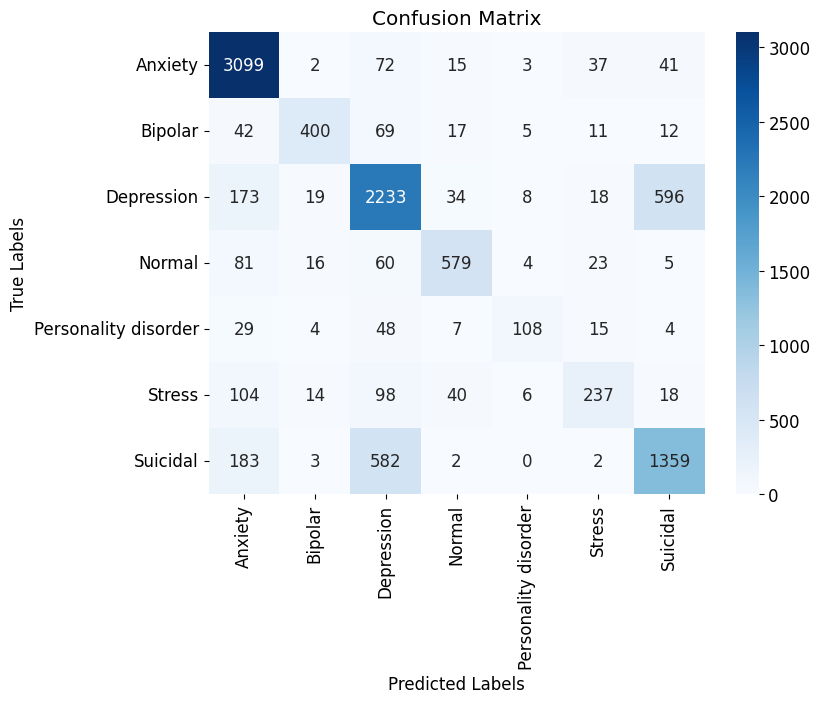

In [31]:
# Evaluate the model 'clf' by using performance metrics like accuracy, precision, recall, F1-score and confusion matrix
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on the test set
y_pred = clf.predict(X_test_tfidf)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))  # Adjust figure size for readability
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=label_encoder.classes_,  # Use class names as labels
    yticklabels=label_encoder.classes_
)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


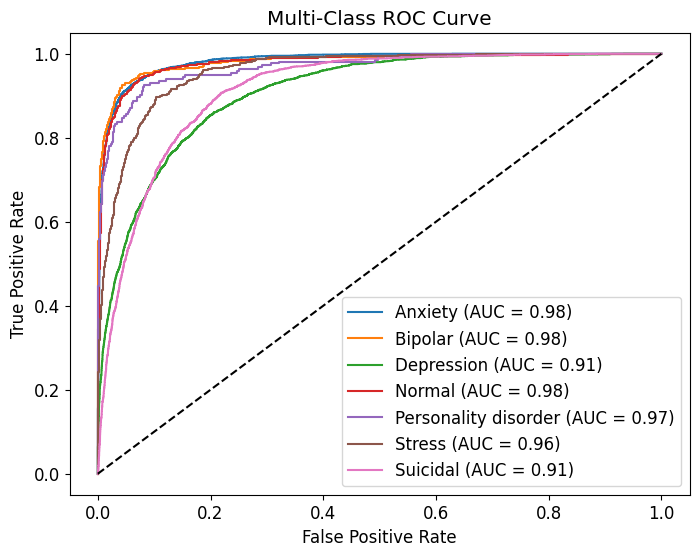

In [35]:

# Compute ROC curve and AUC for each class
from sklearn.metrics import roc_curve, auc # Import roc_curve and auc
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

n_classes = len(label_encoder.classes_)
# Get predicted probabilities (you might need to adjust this based on your model)
y_pred_proba = clf.predict_proba(X_test_tfidf)

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test == i, y_pred_proba[:, i])  # Compute ROC for each class
    roc_auc = auc(fpr, tpr)  # Compute AUC
    plt.plot(fpr, tpr, label=f'{label_encoder.classes_[i]} (AUC = {roc_auc:.2f})')

# Plot the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--')

# Set labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc='lower right')
plt.show()

# **Using the model to make prediction**

In [32]:
# Make prediction using the same sample text for suicide saved as content

# input is in a list format for the vectorizer
content = ["I'm tired of everything. Life feels empty, and I don't see the point of continuing. I just want all this pain to stop forever."]

# Transform the new text using the TF-IDF vectorizer
new_text_tfidf = tfidf_vectorizer.transform(content)

# Predict the category
predicted_label = clf.predict(new_text_tfidf)
print("Predicted Label (numerical):", predicted_label[0])

# Convert the numerical label back to the original category using the mapping
predicted_status = [key for key, value in status_mapping.items() if value == predicted_label[0]]
print("Predicted Status:", predicted_status[0])

Predicted Label (numerical): 6
Predicted Status: Suicidal


MODEL DEPLOYMENT